Task 6.1

Изучим время работы методов analyze1 и analyze2. Для этого будем измерять время их работы на одном массиве данных.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

In [3]:
from thinkdsp import UncorrelatedGaussianNoise
from scipy.stats import linregress

PI2 = np.pi * 2
signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape
loglog = dict(xscale='log', yscale='log')

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = M.dot(ys) / 2
    return amps

def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    decorate(**loglog)
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [4]:
ns = 2 ** np.arange(6, 13)

64
459 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
128
987 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
2.34 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
9.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
37.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
160 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
832 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1.8274494547954714

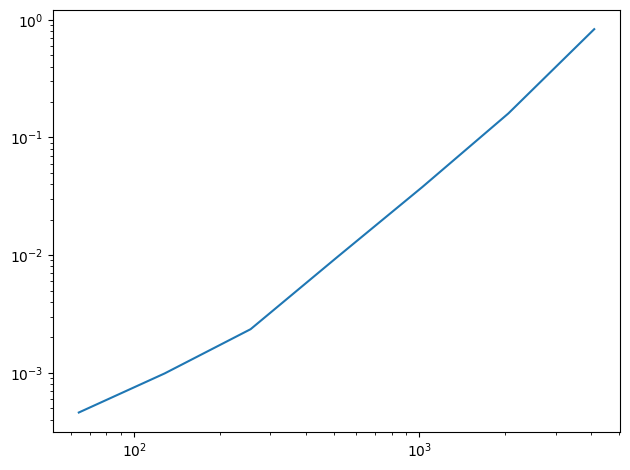

In [6]:
bests1 = run_speed_test(ns, analyze1)
plot_bests(ns, bests1)

64
49 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
173 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
256
547 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
3.41 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
16.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
66.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
267 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.119479875933072

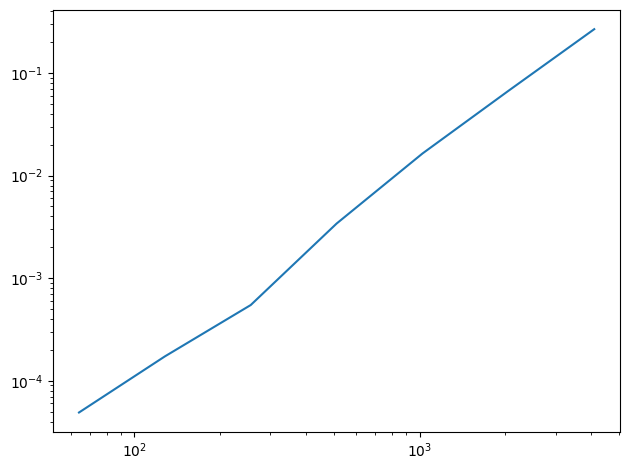

In [5]:
bests = run_speed_test(ns, analyze2)
plot_bests(ns, bests)

Несмотря на то, что метод analyze1 не продемонстировал ожидаемое значение уклона ~3, а полученное значение оказалось даже меньше, чем для второго метода, значение уклона для метода analyze2 совпало с ожидаемым. По результатам для первого метода можно предположить, что на малых массивах данных он показывает себя лучше, но при увеличении размерности будет приближаться к времени выполнения n^3.

Task 6.2

Рассмотрим применение ДКП для сжатия. Возьмем запись игры на скрипке.

In [81]:
from thinkdsp import read_wave

wave = read_wave('92002__jcveliz__violin-origional.wav')
wave.make_audio()

In [82]:
segment = wave.segment(start=0, duration=0.5)
segment.normalize()
segment.make_audio()

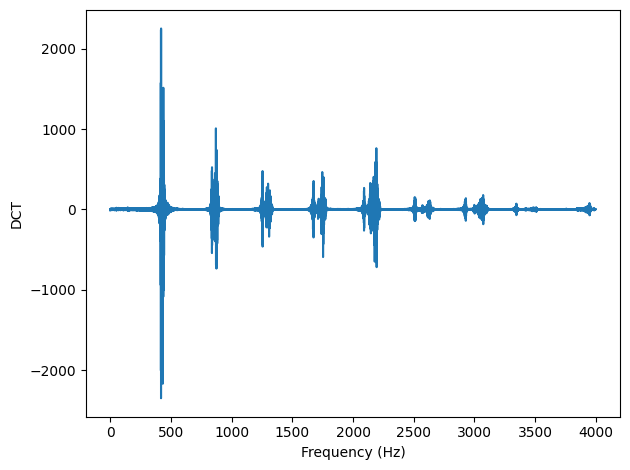

In [83]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

По ДСП сегмента видно, что в районе возле 0 присутствует множество амплитуд. Определим функцию которая уберет амплитуды ниже определенного значения.

In [50]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

20223	22050	91.71428571428571


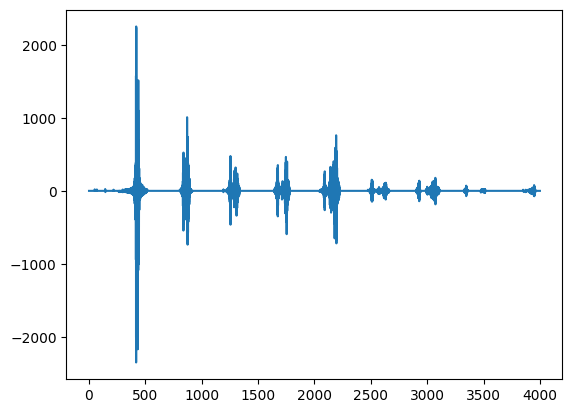

In [84]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=15)
seg_dct.plot(high=4000)

In [85]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Наша функция убрала довольно большое количество элементов с минимальным влиянием на изначельный звук. Попробуем применить данный метод для всей записи. Для этого исходный сигнал разбивается на сегменты, для каждого из которых вычисляется спектограмма ДСП. Ко всем полученным сигментам применяется функция сжатия, и затем сегменты обратно собираются в полную запись.

In [33]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment

    returns: Spectrogram
    """
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

In [95]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.05)

1005	1024	98.14453125
1010	1024	98.6328125
1008	1024	98.4375
1000	1024	97.65625
986	1024	96.2890625
979	1024	95.60546875
988	1024	96.484375
943	1024	92.08984375
951	1024	92.87109375
969	1024	94.62890625
940	1024	91.796875
783	1024	76.46484375
748	1024	73.046875
696	1024	67.96875
661	1024	64.55078125
659	1024	64.35546875
635	1024	62.01171875
612	1024	59.765625
632	1024	61.71875
611	1024	59.66796875
626	1024	61.1328125
598	1024	58.3984375
611	1024	59.66796875
622	1024	60.7421875
616	1024	60.15625
626	1024	61.1328125
647	1024	63.18359375
648	1024	63.28125
636	1024	62.109375
632	1024	61.71875
648	1024	63.28125
637	1024	62.20703125
659	1024	64.35546875
651	1024	63.57421875
478	1024	46.6796875
598	1024	58.3984375
613	1024	59.86328125
626	1024	61.1328125
625	1024	61.03515625
638	1024	62.3046875
649	1024	63.37890625
650	1024	63.4765625
622	1024	60.7421875
649	1024	63.37890625
647	1024	63.18359375
696	1024	67.96875
670	1024	65.4296875
559	1024	54.58984375
643	1024	62.79296875
671	1024	65.527343

In [96]:
wave2 = spectro.make_wave()
wave2.make_audio()

In [97]:
wave.make_audio()

Применив метод сжатия на всю запись, мы смогли добиться значительного уменьшения количества компонент с минимальным влиянием на исходную запись. При дальнейшем повышении порога удаления запись приобретает отчетливые шумы и искажения.

Task 6.3

Рассмотрим пример из блокнота phase.ipynb на другом сегменте.

In [98]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

In [118]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

In [116]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

In [113]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

In [103]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)', 
             ylabel='Phase (radian)')

In [104]:
def plot_three(spectrum, thresh=1):
    """Plot amplitude, phase, and waveform.
    
    spectrum: Spectrum object
    thresh: threshold passed to plot_angle
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

In [99]:
from thinkdsp import read_wave

wave = read_wave('120994__thirsk__120-oboe.wav')
wave.make_audio()

In [110]:
segment = wave.segment(start=5.1, duration=0.9)

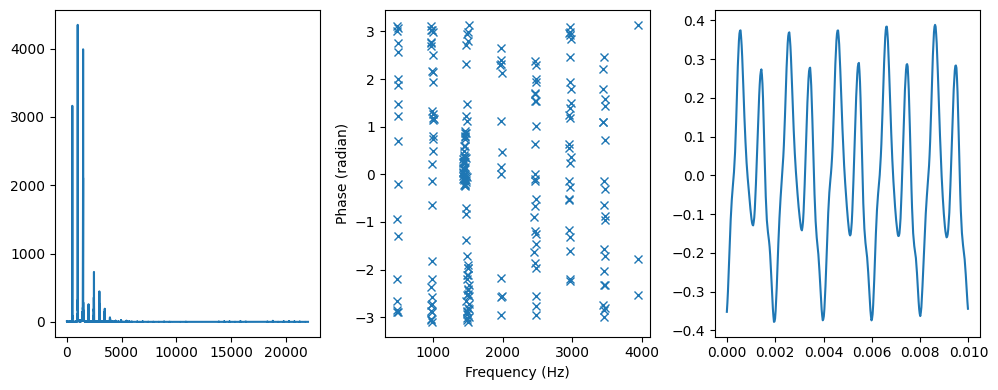

In [111]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

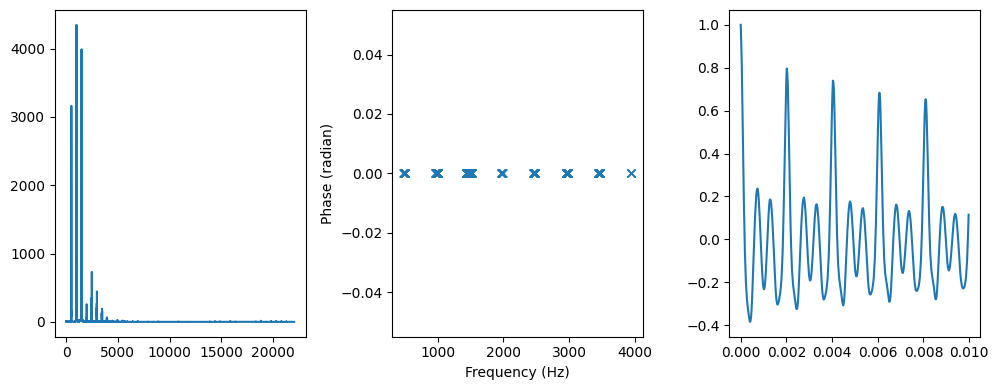

In [114]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

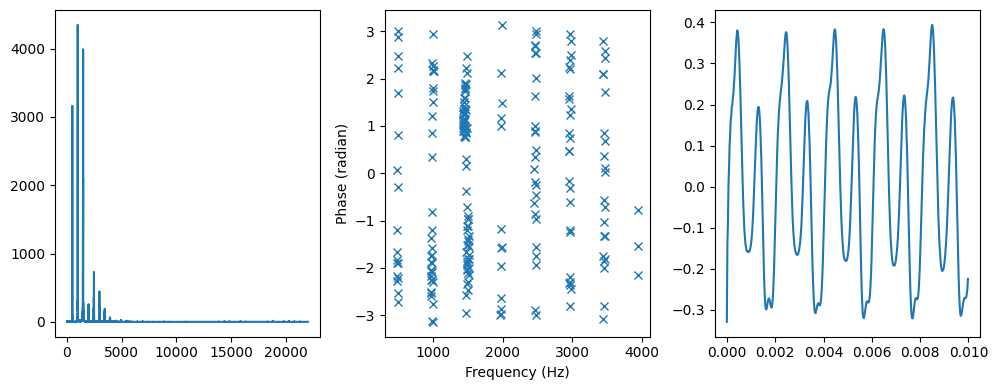

In [117]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

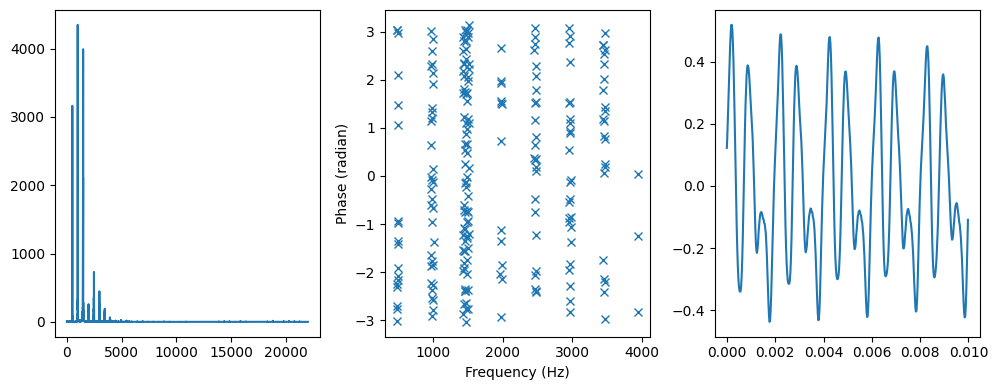

In [120]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Таким образом, рассмотрев другой сегмент исследуемого звука, можно заключить следующее: установка всех компонент в фазовой структуре в 0 вызывает изменения громкости сигнала по времени, поворот угла компонент не оказывает какого-либо различимого влияния, а установка случайного значения как-будто понижает качество звука.